# Inverse design quickstart - level 2

This notebook builds upon the previous [quickstart notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd0Quickstart/) by demonstrating a slightly more advanced inverse design optimization using Tidy3D. In this level 2 notebook, we explore inverse design optimization of a multimode interference (MMI) power splitter. Our inverse design goal is to minimize loss by optimizing the width and length of the MMI.

Throughout this notebook, we will set up the simulation, define the objective function clearly, run an optimization loop, and visualize the optimized field distribution, providing insights into the power of inverse design in integrated photonics.

<img src="img/Adjoint_Quickstart_2.png" width="400" alt="Schematic of the design problem.">

For more advanced inverse design examples and tutorial notebooks, check out

* [Tidy3D Autograd Tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd1Intro/).

* [Topology Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd3InverseDesign/).

* [Shape Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd5BoundaryGradients/).

* [Grating Coupler Inverse Design](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).

To see all Tidy3D [examples](https://www.flexcompute.com/tidy3d/learning-center/example-library/) and [tutorials](https://www.flexcompute.com/tidy3d/learning-center/tidy3d-python/), as well as other learning materials, please visit our [Learning Center](https://www.flexcompute.com/tidy3d/learning-center/).

In [1]:
import autograd as ag
import autograd.numpy as anp
import optax
import tidy3d as td
import tidy3d.web as web

Define a function to create a [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) based on MMI width and length parameters. We set up a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeSource.html) to excite a guided mode and a [ModeMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.ModeMonitor.html) to measure transmission. The width and length will be combined into an array called `param`, where the first element is the width and the second element is the length. Here we only have two design parameters but in principle, this array can have an arbitrary number of parameters.

The MMI geometry is created by a [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PolySlab.html), which is a polygon defined by the coordinates of the vertices. The vertices of the geometry are denoted by the red dots in the schematic below. We manually define the vertices for the top half of the MMI and add a symmetric copy for the vertices on the bottom half.

<img src="img/Adjoint_Quickstart_3.png" width="400" alt="Schematic of the design problem.">

In [2]:
def make_sim(params: anp.ndarray) -> td.Simulation:
    """Create a Tidy3D simulation given MMI width and length parameters."""

    width_mmi = params[0]
    length_mmi = params[1]

    # add a mode source located at the simulation entrance to excite the guided mode
    source = td.ModeSource(
        center=[-1, 0, 0],
        size=[0, 1.5, 1.5],
        source_time=td.GaussianPulse(freq0=td.C_0 / 1.55, fwidth=0.1 * td.C_0 / 1.55),
        mode_spec=td.ModeSpec(),
        direction="+",
    )

    # add a mode monitor located at the simulation exit to measure transmitted mode amplitude
    mode_monitor = td.ModeMonitor(
        name="mode",
        center=[15, 1, 0],
        size=[0, 1.5, 1.5],
        freqs=[td.C_0 / 1.55],
        mode_spec=td.ModeSpec(),
    )

    # add a field monitor to measure the field distribution
    field_monitor = td.FieldMonitor(
        name="field",
        size=[td.inf, td.inf, 0],
        freqs=[td.C_0 / 1.55],
    )

    # define the vertices for the MMI structure geometry
    top_vertices = [
        (-10, 0.25),
        (0, 0.25),
        (0, width_mmi / 2),
        (length_mmi, width_mmi / 2),
        (length_mmi, 1.25),
        (length_mmi + 10, 1.25),
        (length_mmi + 10, 0.75),
        (length_mmi, 0.75),
    ]

    # create the MMI structure using the defined vertices
    mmi = td.Structure(
        geometry=td.PolySlab(
            vertices=top_vertices + [(x, -y) for x, y in reversed(top_vertices)],
            axis=2,
            slab_bounds=(-0.11, 0.11),
        ),
        medium=td.Medium(permittivity=12),
    )

    # create the simulation
    sim = td.Simulation(
        center=[7, 0, 0],
        size=[17, 8, 3],
        symmetry=[0, -1, 1],
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=15),
        run_time=8e-12,
        medium=td.Medium(permittivity=2),
        sources=[source],
        monitors=[mode_monitor, field_monitor],
        structures=[mmi],
    )

    return sim

## Define Objective Function

Define the objective function that calculates transmission based on the MMI structure parameters.

In [ ]:
def objective_fn(params: anp.ndarray) -> float:
    """Compute the objective function, the squared magnitude of the mode amplitude (transmission power) in the forward direction."""

    # run the simulation
    sim_data = web.run(simulation=make_sim(params), task_name="adjoint", verbose=False)

    return (
        anp.abs(sim_data["mode"].amps.sel(direction="+").values.item()) ** 2
    )  # calculate the transmission power

## Optimization Loop

Next, we use `autograd` to construct a function that returns the gradient of our objective function and use this to run our gradient-based optimization in a for loop. Instead of the plain gradient descent, here we use the more robust [adam optimizer](https://optax.readthedocs.io/en/latest/api/optimizers.html#optax.adam) from the open-source library `optax`.

In [4]:
# use autograd to get a function that returns the objective function and its gradient
val_grad = ag.value_and_grad(objective_fn)

# initial design parameters are 4 μm width and 13 μm length
params = anp.array([4.0, 13.0])

# initialize adam optimizer with starting parameters
optimizer = optax.adam(learning_rate=0.01)
opt_state = optimizer.init(params)

for i in range(7):
    # compute gradient and current objective function value
    value, gradient = val_grad(params)

    # compute and apply updates to the optimizer based on gradient
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    print(f"step = {i + 1}")
    print(f"\ttransmission = {1e2 * value:.1f}%")

step = 1
	transmission = 28.5%
step = 2
	transmission = 37.8%
step = 3
	transmission = 41.7%
step = 4
	transmission = 43.0%
step = 5
	transmission = 43.6%
step = 6
	transmission = 43.9%
step = 7
	transmission = 43.8%


## Analysis

During the optimization, we can see that the transmission is significantly increased. The final transmission is close to 44%, over 15% higher than the initial design. Finally, we run a simulation using the optimized parameters and visualize the resulting electric field distribution, which shows nice power splitting.

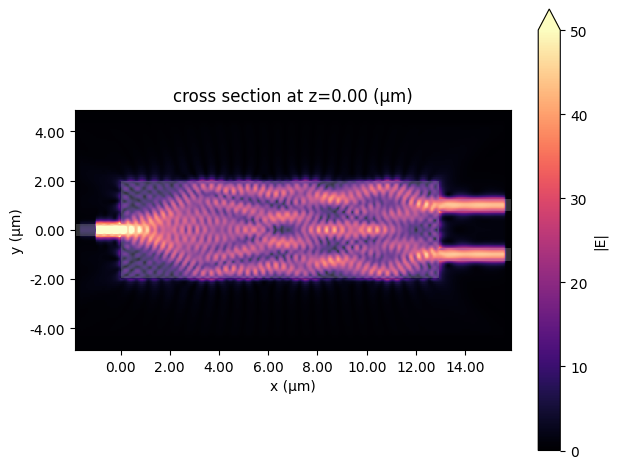

In [5]:
data_final = web.run(simulation=make_sim(params), task_name="optimized_mmi", verbose=False)

data_final.plot_field("field", "E", "abs", vmin=0, vmax=50);